In [ ]:
!gdown --id 1egcloERTpWn8pYfVF05_ne1UfXRkVUHx

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1egcloERTpWn8pYfVF05_ne1UfXRkVUHx
To: /content/IMDB_Dataset.csv
100% 66.2M/66.2M [00:00<00:00, 118MB/s]


In [ ]:
!gdown --id 1p5BnUMZNvNTFuS7cvOc3sQOUvLM9g3kh

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1p5BnUMZNvNTFuS7cvOc3sQOUvLM9g3kh
To: /content/glove.6B.100d.txt
100% 347M/347M [00:02<00:00, 146MB/s]


In [ ]:
import pandas as pd


df = pd.read_csv('/content/IMDB_Dataset.csv')


print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Bidirectional



nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # We Converted it to lowercase
    text = text.lower()

    # We Removed punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # We Removed stopwords
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]

    # We Joined the words back into a sentence
    processed_text = ' '.join(words)

    return processed_text

# We applied preprocessing to the 'review' column
df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

import numpy as np


embeddings_index = {}
with open('/content/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])

max_length = 256
X = pad_sequences(sequences, maxlen=max_length)


word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)


In [ ]:


#Trying to play with hyperparameters like changing batch size using Baseline model
model_baseline = Sequential()
model_baseline.add(Embedding(num_words, 100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_baseline.add(Dense(10, activation='relu'))
model_baseline.add(Dense(1, activation='sigmoid'))

model_baseline.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Converting y to numeric data
y_train_numeric = (y_train == 'positive').astype(float)
y_test_numeric = (y_test == 'positive').astype(float)
model_baseline.fit(X_train, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test, y_test_numeric))


Epoch 1/20
1250/1250 [==============================] - 23s 16ms/step - loss: 0.6900 - accuracy: 0.5189 - val_loss: 0.6879 - val_accuracy: 0.5267
Epoch 2/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6875 - accuracy: 0.5279 - val_loss: 0.6873 - val_accuracy: 0.5281
Epoch 3/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6872 - accuracy: 0.5244 - val_loss: 0.6869 - val_accuracy: 0.5248
Epoch 4/20
1250/1250 [==============================] - 9s 8ms/step - loss: 0.6868 - accuracy: 0.5264 - val_loss: 0.6867 - val_accuracy: 0.5255
Epoch 5/20
1250/1250 [==============================] - 9s 7ms/step - loss: 0.6866 - accuracy: 0.5269 - val_loss: 0.6863 - val_accuracy: 0.5264
Epoch 6/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.6866 - accuracy: 0.5271 - val_loss: 0.6863 - val_accuracy: 0.5265
Epoch 7/20
1250/1250 [==============================] - 8s 7ms/step - loss: 0.6864 - accuracy: 0.5290 - val_loss: 0.6862 - val_accu

In [ ]:
loss_baseline, accuracy_baseline = model_baseline.evaluate(X_test, y_test_numeric)
print(f'Baseline Model - Accuracy: {accuracy_baseline*100:.2f}%')

313/313 [==============================] - 2s 6ms/step - loss: 0.6859 - accuracy: 0.5272
Baseline Model - Accuracy: 52.72%


In [ ]:
# Shallow model
model_shallow = Sequential()
model_shallow.add(Embedding(num_words, 100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_shallow.add(Dense(10, activation='relu'))
model_shallow.add(Dense(1, activation='sigmoid'))

model_shallow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_shallow.fit(X_train, y_train_numeric , epochs=20, batch_size=32, validation_split = 0.2)


Epoch 1/20
1000/1000 [==============================] - 9s 8ms/step - loss: 0.6908 - accuracy: 0.5175 - val_loss: 0.6881 - val_accuracy: 0.5220
Epoch 2/20
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6877 - accuracy: 0.5250 - val_loss: 0.6877 - val_accuracy: 0.5266
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6872 - accuracy: 0.5271 - val_loss: 0.6870 - val_accuracy: 0.5253
Epoch 4/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6870 - accuracy: 0.5264 - val_loss: 0.6867 - val_accuracy: 0.5288
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6868 - accuracy: 0.5250 - val_loss: 0.6869 - val_accuracy: 0.5250
Epoch 6/20
1000/1000 [==============================] - 7s 7ms/step - loss: 0.6866 - accuracy: 0.5264 - val_loss: 0.6865 - val_accuracy: 0.5299
Epoch 7/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6865 - accuracy: 0.5277 - val_loss: 0.6865 - val_accurac

In [ ]:
loss_shallow, accuracy_shallow = model_shallow.evaluate(X_test, y_test_numeric)
print(f'Shallow Model - Accuracy: {accuracy_shallow*100:.2f}%')

313/313 [==============================] - 2s 4ms/step - loss: 0.6861 - accuracy: 0.5270
Shallow Model - Accuracy: 52.70%


In [ ]:
model_lstm_uni = Sequential()
model_lstm_uni.add(Embedding(num_words, 100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_lstm_uni.add(LSTM(10, activation='relu'))
model_lstm_uni.add(Dense(1, activation='sigmoid'))

model_lstm_uni.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_uni.fit(X_train, y_train_numeric, epochs=20, batch_size=32,validation_split = 0.2)

Epoch 1/20
1000/1000 [==============================] - 71s 69ms/step - loss: 0.7413 - accuracy: 0.6025 - val_loss: 0.6358 - val_accuracy: 0.6501
Epoch 2/20
1000/1000 [==============================] - 63s 63ms/step - loss: 0.5775 - accuracy: 0.7041 - val_loss: 0.5015 - val_accuracy: 0.7729
Epoch 3/20
1000/1000 [==============================] - 66s 66ms/step - loss: 0.4551 - accuracy: 0.7929 - val_loss: 0.4308 - val_accuracy: 0.8074
Epoch 4/20
1000/1000 [==============================] - 63s 63ms/step - loss: 0.4082 - accuracy: 0.8181 - val_loss: 0.4024 - val_accuracy: 0.8210
Epoch 5/20
1000/1000 [==============================] - 68s 68ms/step - loss: 0.3794 - accuracy: 0.8333 - val_loss: 0.3674 - val_accuracy: 0.8391
Epoch 6/20
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3563 - accuracy: 0.8464 - val_loss: 0.3497 - val_accuracy: 0.8479
Epoch 7/20
1000/1000 [==============================] - 64s 64ms/step - loss: 0.3397 - accuracy: 0.8574 - val_loss: 0.3600 -

In [ ]:
loss_shallow, accuracy_lstm_uni = model_lstm_uni.evaluate(X_test, y_test_numeric)
print(f'LSTM Uniderictional Model- Accuracy: {accuracy_lstm_uni*100:.2f}%')

313/313 [==============================] - 7s 21ms/step - loss: 0.3464 - accuracy: 0.8518
LSTM Uniderictional Model- Accuracy: 85.18%


In [ ]:
from keras.layers import Bidirectional

model_lstm_bi = Sequential()
model_lstm_bi.add(Embedding(num_words, 100, input_length=max_length, weights=[embedding_matrix], trainable=False))
model_lstm_bi.add(Bidirectional(LSTM(10, activation='relu')))
model_lstm_bi.add(Dense(1, activation='sigmoid'))

model_lstm_bi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_bi.fit(X_train, y_train_numeric , epochs=20, batch_size=32,validation_split = 0.2)


Epoch 1/20
1000/1000 [==============================] - 105s 103ms/step - loss: 17.4169 - accuracy: 0.7497 - val_loss: 0.3926 - val_accuracy: 0.8276
Epoch 2/20
1000/1000 [==============================] - 108s 108ms/step - loss: 0.3866 - accuracy: 0.8295 - val_loss: 0.4042 - val_accuracy: 0.8201
Epoch 3/20
1000/1000 [==============================] - 106s 106ms/step - loss: 0.3547 - accuracy: 0.8456 - val_loss: 0.3456 - val_accuracy: 0.8503
Epoch 4/20
1000/1000 [==============================] - 103s 103ms/step - loss: 0.3376 - accuracy: 0.8531 - val_loss: 0.3365 - val_accuracy: 0.8541
Epoch 5/20
1000/1000 [==============================] - 105s 105ms/step - loss: 0.3236 - accuracy: 0.8608 - val_loss: 0.3369 - val_accuracy: 0.8569
Epoch 6/20
1000/1000 [==============================] - 105s 105ms/step - loss: 0.3145 - accuracy: 0.8662 - val_loss: 0.3194 - val_accuracy: 0.8618
Epoch 7/20
1000/1000 [==============================] - 109s 109ms/step - loss: 0.3057 - accuracy: 0.8701 - val

In [ ]:
loss_shallow, accuracy_lstm_bi = model_lstm_bi.evaluate(X_test, y_test_numeric)
print(f'LSTM Biderictional Model- Accuracy: {accuracy_lstm_bi*100:.2f}%')

313/313 [==============================] - 11s 34ms/step - loss: 0.3104 - accuracy: 0.8674
LSTM Biderictional Model- Accuracy: 86.74%


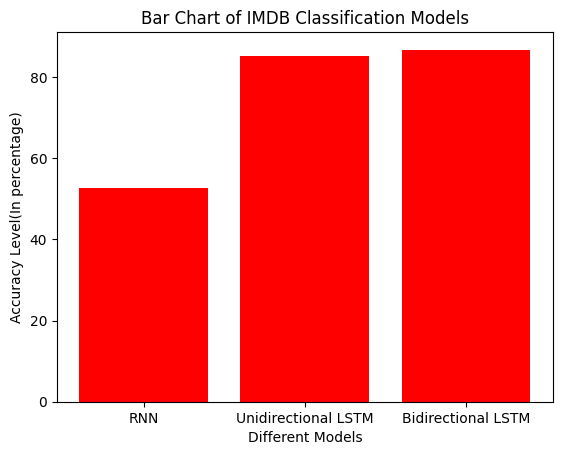

In [ ]:
import matplotlib.pyplot as plt
x_axis = ['RNN', 'Unidirectional LSTM', 'Bidirectional LSTM']
y_axis = [accuracy_shallow*100, accuracy_lstm_uni*100, accuracy_lstm_bi*100]

plt.bar(x_axis, y_axis,color= 'red')
plt.title('Bar Chart of IMDB Classification Models')
plt.xlabel('Different Models')
plt.ylabel('Accuracy Level(In percentage)')
plt.show()